# Facial Expression Recognition with ResNet50

This notebook implements a facial expression classifier using the ResNet50 architecture. The model is trained on grayscale images converted to 3-channel format for compatibility with ResNet50.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to access datasets and models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import importlib
os.chdir('/content/drive/MyDrive/adne_imagen') # Navigate to project directory

# Force reload the module to make sure we have the latest changes
import src.dl_model_utils
importlib.reload(src.dl_model_utils)
from src.dl_model_utils import *

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# Configuration
IMG_SIZE = (224, 224)  # Standard ResNet size
BATCH_SIZE = 16
CHANNELS = 3         # For RGB images (ResNet50 requires 3-channel input)

## 1. Data Preparation

Before training the model, we load the preprocessed training and test datasets.    
This step also includes displaying the number of samples and the distribution of emotion classes in both sets, 
which is essential to evaluate dataset balance and ensure representative training.

In [ ]:
# Load and display dataset info
train_df = pd.read_csv("dataset/balanced_train_regruped_classes.csv")
test_df = pd.read_csv("dataset/balanced_test_regruped_classes.csv")

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['Regruped Emotion'].value_counts())
print("\nClass distribution in test set:")
print(test_df['Regruped Emotion'].value_counts())

Training samples: 9000
Test samples: 2232

Class distribution in training set:
Regruped Emotion
negative    3000
neutral     3000
positive    3000
Name: count, dtype: int64

Class distribution in test set:
Regruped Emotion
negative    744
neutral     744
positive    744
Name: count, dtype: int64


The dataset is well-balanced across the three emotion classes—negative, neutral, and positive—both      
in the training set (9000 samples) and test set (2232 samples). This balanced distribution helps prevent model bias toward any particular class.


In [ ]:
# Fix path format for compatibility
train_df["image_path"] = train_df["image_path"].str.replace("\\", "/")
test_df["image_path"] = test_df["image_path"].str.replace("\\", "/")

In [ ]:
train_df.head()

,filename,Original Emotion,Emotion,Regruped Emotion,image_path
0,Training_23314296.jpg,angry,angry,negative,dataset/train/angry/Training_23314296.jpg
1,Training_18596885.jpg,sad,sad,negative,dataset/train/sad/Training_18596885.jpg
2,Training_31146992.jpg,sad,sad,negative,dataset/train/sad/Training_31146992.jpg
3,Training_43183239.jpg,sad,sad,negative,dataset/train/sad/Training_43183239.jpg
4,Training_79856176.jpg,angry,angry,negative,dataset/train/angry/Training_79856176.jpg


We define data generators for training, validation, and testing. These generators handle image preprocessing and     
augmentation, and they ensure that data is fed into the model in batches with the correct format (RGB and categorical labels) for ResNet50.

In [ ]:
# Create data generators for training and validation using categorical class mode and RGB images
train_gen, val_gen = get_data_generators(
    train_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    val_split=0.2,
    seed=42,
    x_col='image_path',
    y_col='Regruped Emotion',
    color_mode='rgb'
)

# Get test generator
test_gen = get_test_generator(
    test_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    x_col='image_path',
    y_col='Regruped Emotion',
    color_mode='rgb'
)

num_classes = len(train_gen.class_indices)
print("Number of classes:", num_classes)
print("Class mapping:", train_gen.class_indices)

# Input shape includes channel (3 for Resnet50)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

Found 7200 validated image filenames belonging to 3 classes.
Found 1800 validated image filenames belonging to 3 classes.
Found 2232 validated image filenames belonging to 3 classes.
Number of classes: 3
Class mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


The data generators successfully loaded 7200 training images, 1800 validation images, and 2232 test images, all     
evenly distributed across the three emotion classes. The class labels are correctly mapped to integer indices, which will be used during model training.


## 2. Check Sample Images

To ensure that images are being correctly loaded and labeled by the data generator, we display a few samples from the     
 training batch. This step helps verify that the preprocessing pipeline is working as expected (e.g., correct color mode, size,    
 and label assignment). Each image is shown with its corresponding emotion class name and index.

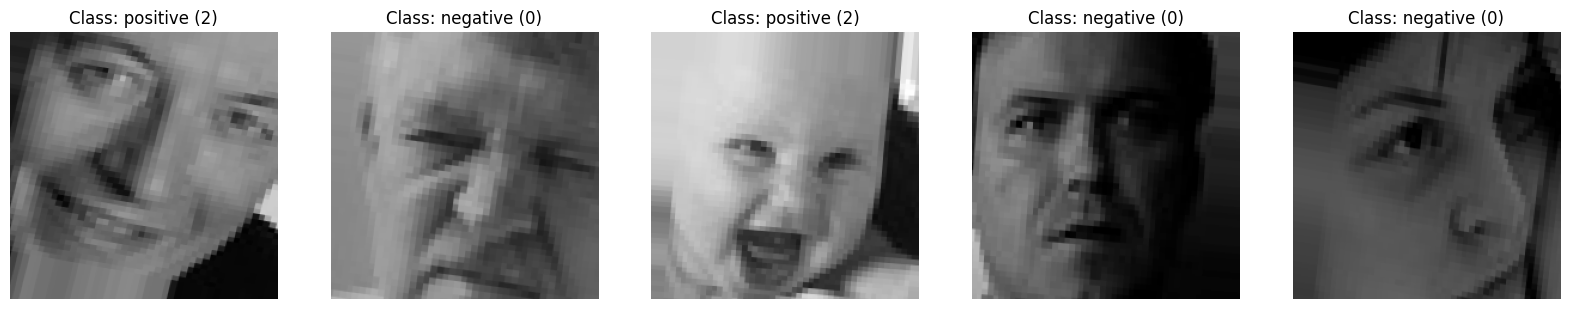

In [ ]:
# Display a few samples from the dataset to verify loading
batch_x, batch_y = next(train_gen)
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_x[i])  # RGB images don't need reshaping

    # Since we're using categorical mode, we need to get the class index
    class_idx = np.argmax(batch_y[i])
    class_name = list(train_gen.class_indices.keys())[class_idx]
    plt.title(f"Class: {class_name} ({class_idx})")
    plt.axis('off')
plt.show()

## 3. Build and Train ResNet50 Model

We construct the ResNet50-based model using transfer learning. The pre-trained ResNet50 weights (trained on ImageNet) are loaded, and the initial layers are optionally frozen to retain learned low-level features. The model is then customized to fit our classification task with three emotion classes. The summary provides an overview of the architecture, including trainable and non-trainable layers.

In [ ]:
# Build the ResNet50 model with transfer learning
resnet50_model = build_resnet50(input_shape, num_classes, freeze_layers=True)
resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,212,227 (99.99 MB)

 Trainable params: 2,624,515 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
with tf.device('/GPU:0'):
  # Initial training with frozen layers
  print("Phase 1: Training with frozen ResNet50 base layers...")
  history_resnet50 = train_model(
      resnet50_model,
      train_gen,
      val_gen,
      epochs=20,
      out_path='models/resnet50_best.keras'
  )

Phase 1: Training with frozen ResNet50 base layers...
Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3343 - loss: 1.2015

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.11772, saving model to models/resnet50_best.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3370s 7s/step - accuracy: 0.3343 - loss: 1.2015 - val_accuracy: 0.3333 - val_loss: 1.1177 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3179 - loss: 1.1289
Epoch 2: val_loss improved from 1.11772 to 1.10204, saving model to models/resnet50_best.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 200s 445ms/step - accuracy: 0.3179 - loss: 1.1289 - val_accuracy: 0.3372 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3335 - loss: 1.1110
Epoch 3: val_loss improved from 1.10204 to 1.09914, saving model to models/resnet50_best.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 201s 445ms/step - accuracy: 0.3334 - loss: 1.1110 - val_accuracy: 0.3344 - val_loss: 1.0991 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.3247 - loss: 1.1076
Epoch 4: 

In this phase, we train the top layers of the model while keeping the pre-trained ResNet50 base frozen. This allows the model to begin learning features specific to our emotion classification task without altering the generic image features already learned from ImageNet.

The training is set to run for 20 epochs using a learning rate of 1e-4. The model is evaluated on the validation set after each epoch, and the best-performing weights (based on validation loss) are saved.

**Observations:**
- Validation loss slightly decreases during the first several epochs, indicating slow but steady learning.
- Both training and validation accuracy hover around ~33–35%, which is close to random guessing for a 3-class problem. This suggests that the frozen base might be limiting learning.

In [ ]:
best_model = load_model('models/resnet50_best.keras')

In [ ]:
history_finetuned = unfreeze_and_finetune(
    best_model,
    train_gen,
    val_gen,
    n_layers=1,
    epochs=10,
    out_path='models/resnet50_finetuned2.keras'
)

Unfrozen last 2 layers: ['dropout_1', 'dense_2']


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3413 - loss: 1.0985
Epoch 1: val_loss improved from inf to 1.09772, saving model to models/resnet50_finetuned2.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3173s 7s/step - accuracy: 0.3413 - loss: 1.0985 - val_accuracy: 0.3500 - val_loss: 1.0977 - learning_rate: 1.0000e-05
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3365 - loss: 1.0981
Epoch 2: val_loss did not improve from 1.09772
450/450 ━━━━━━━━━━━━━━━━━━━━ 1774s 4s/step - accuracy: 0.3366 - loss: 1.0981 - val_accuracy: 0.3433 - val_loss: 1.0979 - learning_rate: 1.0000e-05
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3444 - loss: 1.0981
Epoch 3: val_loss did not improve from 1.09772
450/450 ━━━━━━━━━━━━━━━━━━━━ 1832s 4s/step - accuracy: 0.3444 - loss: 1.0981 - val_accuracy: 0.3400 - val_loss: 1.0979 - learning_rate: 1.0000e-05
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3472 - loss: 1.0982
Epoch 4: val_loss improved f

After initial training with the base ResNet50 layers frozen, we proceed to fine-tune the model by unfreezing the last two layers (`'dropout_1'` and `'dense_2'`). This allows the model to slightly adjust its high-level learned features to better suit the facial expression classification task.

Fine-tuning is performed with a lower learning rate (`1e-5`) to avoid large updates that could disrupt the pre-trained weights. The model is trained for 10 additional epochs.

**Observations:**
- Accuracy remains relatively stable around 33–35%, indicating that the model is still not learning meaningful patterns specific to the task.
- The validation loss does show marginal improvements across a few epochs, but the gains are minimal.
- This stagnation suggests a few possibilities:
  - The dataset may be too small or lacking in variability to effectively fine-tune a deep network like ResNet50.
  - The emotion labels might be too abstract or visually subtle for the model to learn with the current setup.
  - Further data augmentation, a simpler architecture, or a different loss function (e.g., focal loss) might help.

Overall, while the model is technically fine-tuned, its performance is still close to random chance, indicating that deeper changes in training strategy may be needed.

In [ ]:
history_finetuned = unfreeze_and_finetune(
    best_model,
    train_gen,
    val_gen,
    n_layers=2,
    epochs=10,
    out_path='models/resnet50_finetuned2.keras'
)

Phase 2: Fine-tuning - Unfreezing base layers and training with lower learning rate...
Last layer unfrozen: dense_2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3435 - loss: 1.0986
Epoch 1: val_loss improved from inf to 1.09808, saving model to models/resnet50_finetuned.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3749s 8s/step - accuracy: 0.3435 - loss: 1.0986 - val_accuracy: 0.3622 - val_loss: 1.0981 - learning_rate: 1.0000e-05
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.3378 - loss: 1.0983
Epoch 2: val_loss did not improve from 1.09808
450/450 ━━━━━━━━━━━━━━━━━━━━ 197s 438ms/step - accuracy: 0.3378 - loss: 1.0983 - val_accuracy: 0.3533 - val_loss: 1.0983 - learning_rate: 1.0000e-05
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3490 - loss: 1.0968
Epoch 3: val_loss improved from 1.09808 to 1.09757, saving model to models/resnet50_finetuned.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 199s 442ms/step - accuracy: 0.3490 - loss: 1.0968 - val_accuracy: 0.3594 - val_loss: 1.0976 - learning_rate: 1.0000e-05
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/st

In this updated fine-tuning attempt, only the final layer (`dense_2`) of the ResNet50 base model was unfrozen to mitigate overfitting and reduce the risk of destabilizing the pretrained weights. The training was conducted with a low learning rate (`1e-5`), and learning rate reduction on plateau was used to help the optimizer converge.

**Key observations:**
- The model showed minimal improvement in validation loss, with only a slight decrease by epoch 3, after which performance plateaued.
- Validation accuracy hovered around 35%, indicating limited learning progress.
- Early stopping was triggered due to lack of further improvement, and the best model weights were restored.

This outcome suggests that even with more conservative fine-tuning, the model struggles to extract discriminative features for emotion classification in this setting. Additional strategies like better data augmentation, a custom CNN, or incorporating domain-specific preprocessing (e.g., face alignment, facial landmarks) could be explored to improve performance.

## 4. Evaluate on Test Set

In [ ]:
# Load and evaluate the best fine-tuned model
final_model = load_model('models/resnet50_finetuned.keras')
test_loss, test_acc = final_model.evaluate(test_gen)
print(f'Test accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 769s 5s/step - accuracy: 0.2586 - loss: 1.1003
Test accuracy: 0.3616


## 5. Visualize Test Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


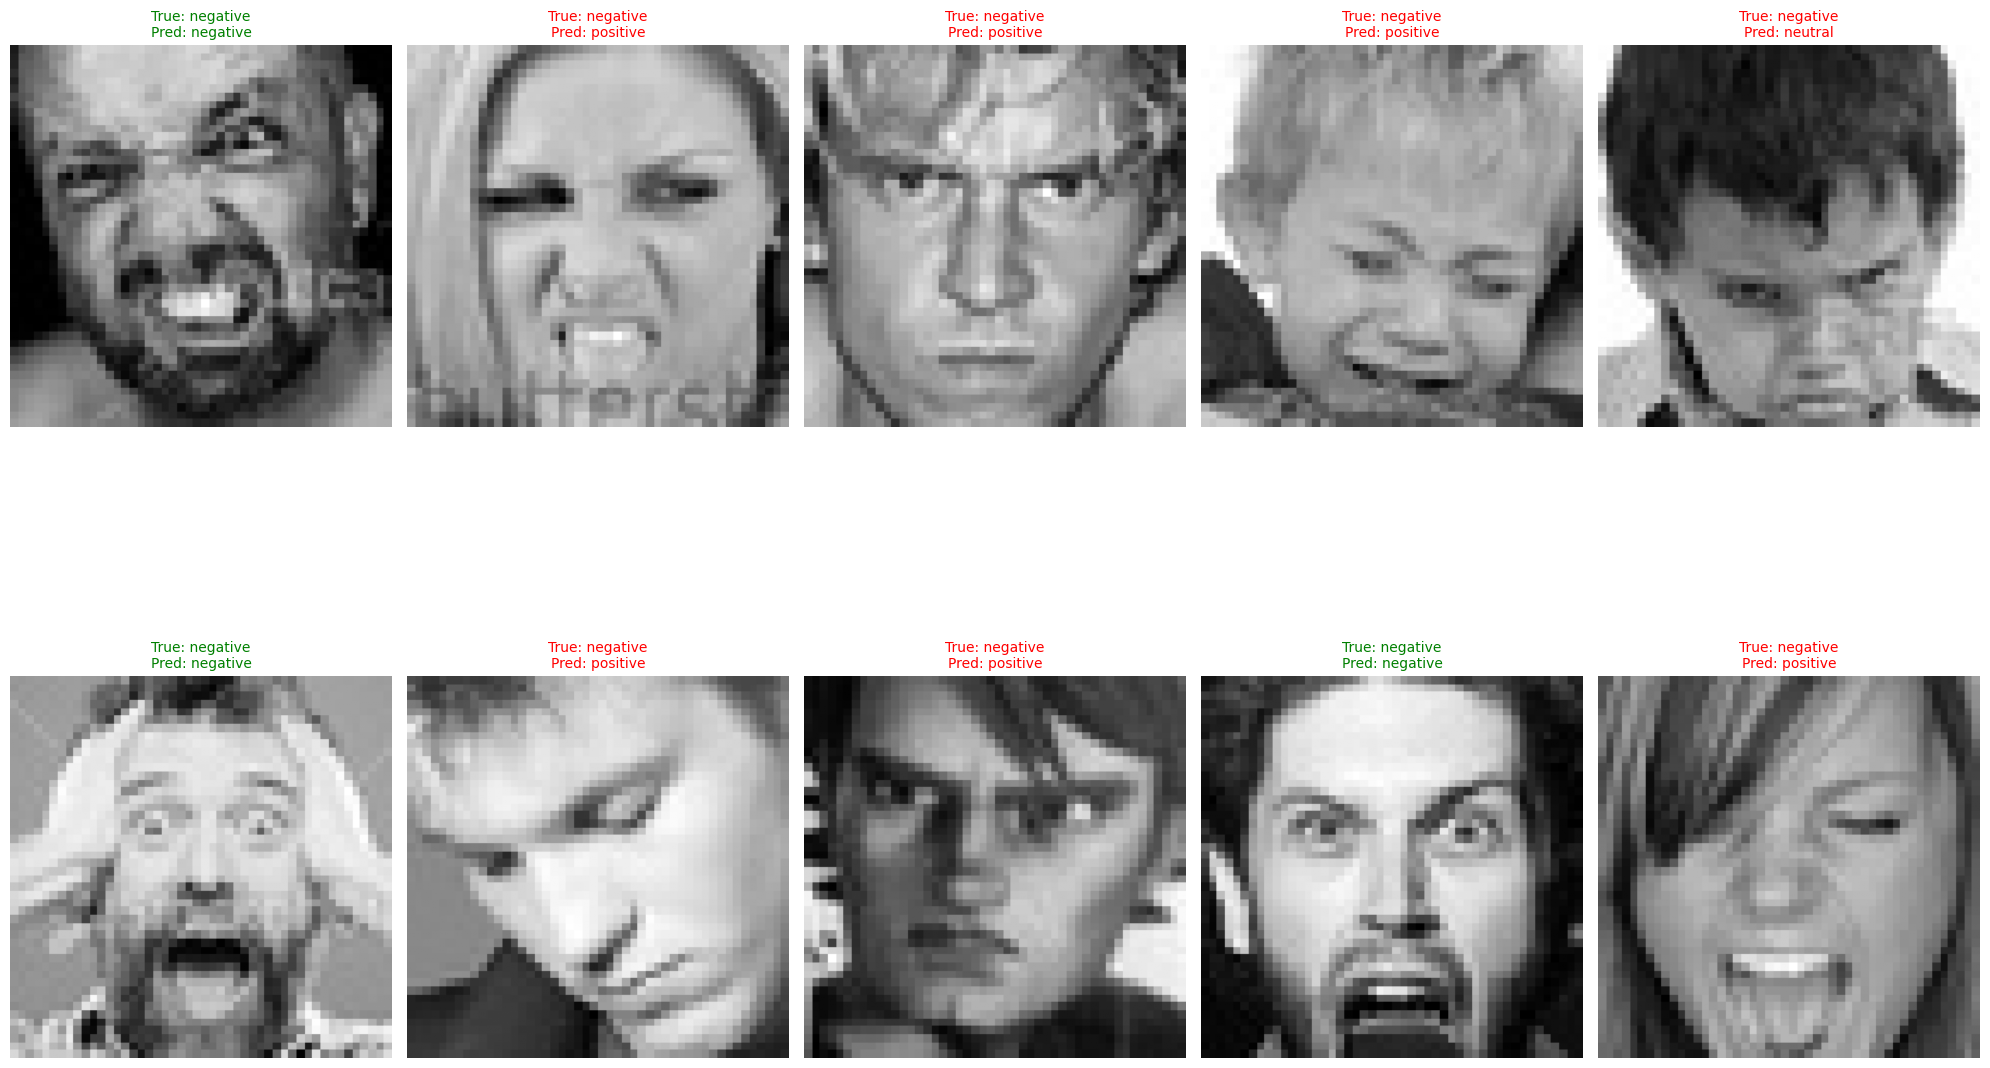

In [ ]:
# Use the visualization function to display predictions
visualize_predictions(final_model, test_gen, test_gen.class_indices, num_samples=10)

## 6. Confusion Matrix and Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/

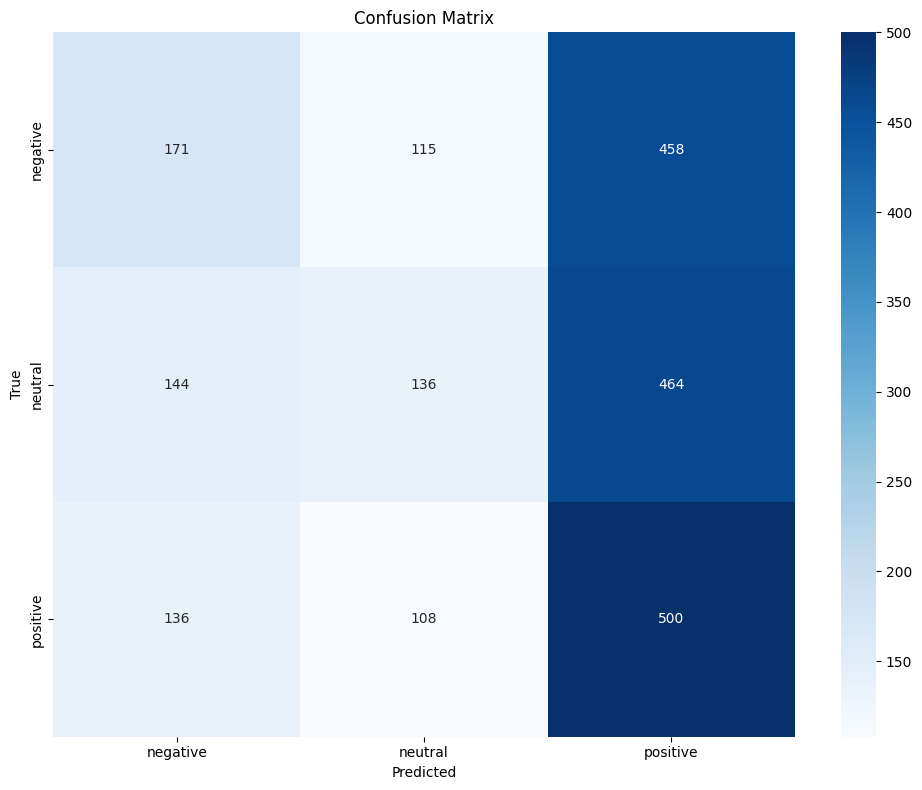

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      0.23      0.29       744
     neutral       0.38      0.18      0.25       744
    positive       0.35      0.67      0.46       744

    accuracy                           0.36      2232
   macro avg       0.37      0.36      0.33      2232
weighted avg       0.37      0.36      0.33      2232

Overall Accuracy: 0.3616
Macro F1 Score: 0.3315


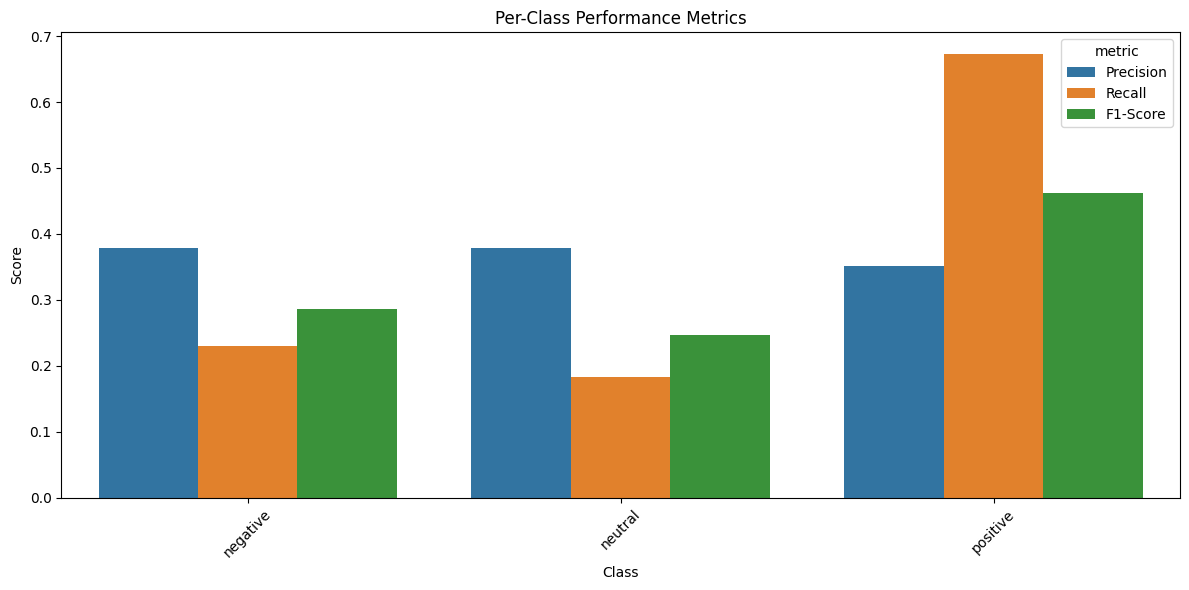

Worst performing classes by F1-score:
      Class  Precision    Recall  F1-Score
1   neutral   0.378830  0.182796  0.246600
0  negative   0.379157  0.229839  0.286192
2  positive   0.351617  0.672043  0.461681


In [ ]:
# Evaluate the model and get metrics
metrics = evaluate_model(final_model, test_gen)
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {metrics['f1_macro']:.4f}")

# Get per-class metrics
class_names = list(test_gen.class_indices.keys())
class_metrics = evaluate_model_per_class(metrics, class_names)

# View the worst performing classes
print("Worst performing classes by F1-score:")
print(class_metrics.sort_values('F1-Score').head(3))